# Moment curvature analysis

In [1]:
import numpy as np
from sectionproperties.pre.library import circular_section, rectangular_section

import concreteproperties.stress_strain_profile as ssp
from concreteproperties import (
    Concrete,
    ConcreteSection,
    SteelBar,
    add_bar_rectangular_array,
)
from concreteproperties.results import MomentCurvatureResults

from sectionproperties.analysis import Section
from sectionproperties.pre import CompoundGeometry, Geometry

Using PARDISO solver


In [2]:
conc_linear = Concrete(
    name="Linear Concrete",
    density=2.4e-6,
    stress_strain_profile=ssp.ConcreteLinear(
        elastic_modulus=35e3, ultimate_strain=0.0035
    ),
    ultimate_stress_strain_profile=ssp.BilinearStressStrain(
        compressive_strength=40,
        compressive_strain=0.00175,
        ultimate_strain=0.0035,
    ),
    flexural_tensile_strength=3.5,
    colour="lightgrey",
)

conc_linear_no_tension = Concrete(
    name="Linear Concrete (No T)",
    density=2.4e-6,
    stress_strain_profile=ssp.ConcreteLinearNoTension(
        elastic_modulus=35e3, ultimate_strain=0.0035
    ),
    ultimate_stress_strain_profile=ssp.BilinearStressStrain(
        compressive_strength=40,
        compressive_strain=0.00175,
        ultimate_strain=0.0035,
    ),
    flexural_tensile_strength=3.5,
    colour="lightgrey",
)


conc_nonlinear = Concrete(
    name="Non-Linear Concrete",
    density=2.4e-6,
    stress_strain_profile=ssp.EurocodeNonLinear(
        elastic_modulus=35e3,
        ultimate_strain=0.0035,
        compressive_strength=40,
        compressive_strain=0.0023,
        tensile_strength=3.5,
        tension_softening_stiffness=10e3,
    ),
    ultimate_stress_strain_profile=ssp.BilinearStressStrain(
        compressive_strength=40,
        compressive_strain=0.00175,
        ultimate_strain=0.0035,
    ),
    flexural_tensile_strength=3.5,
    colour="lightgrey",
)

conc_material_list = [
    conc_linear,
    conc_linear_no_tension,
    conc_nonlinear,
]

steel = SteelBar(
    name="Steel - Elastic-Plastic",
    density=7.85e-6,
    stress_strain_profile=ssp.SteelElasticPlastic(
        yield_strength=500,
        elastic_modulus=200e3,
        fracture_strain=0.05,
    ),
    colour="grey",
)

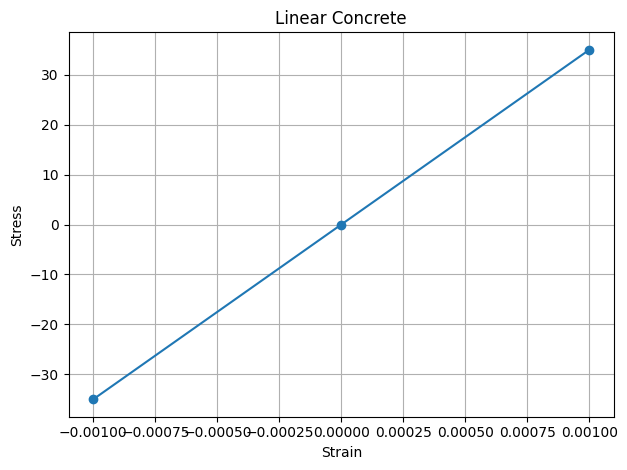

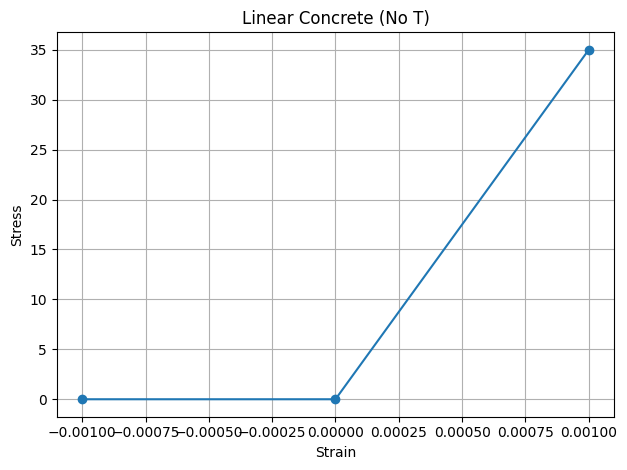

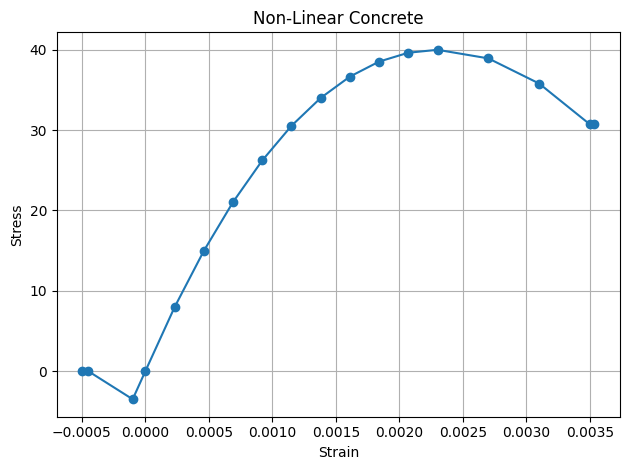

In [3]:
for conc in conc_material_list:
    conc.stress_strain_profile.plot_stress_strain(title=conc.name)

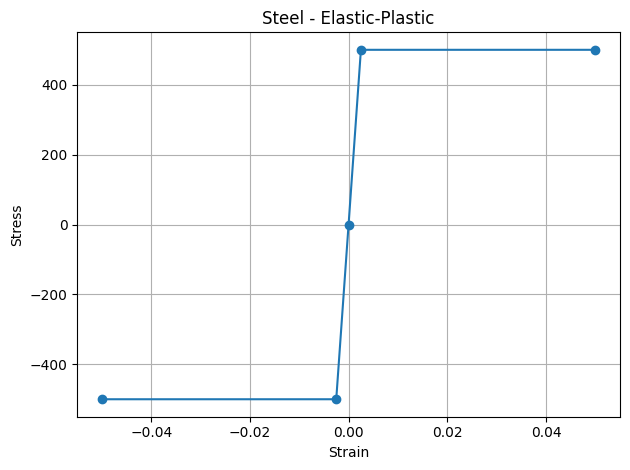

<Axes: title={'center': 'Steel - Elastic-Plastic'}, xlabel='Strain', ylabel='Stress'>

In [4]:
steel.stress_strain_profile.plot_stress_strain(title=steel.name)

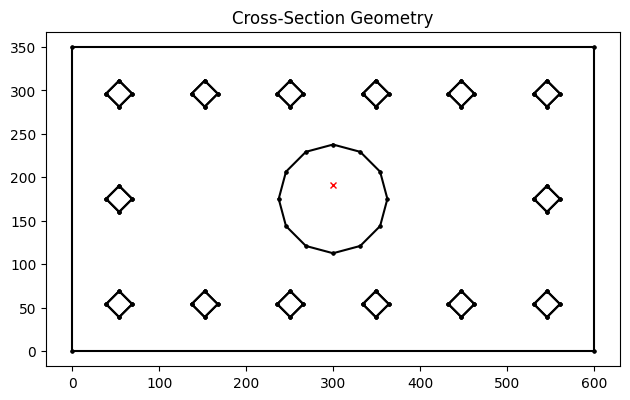

<Axes: title={'center': 'Cross-Section Geometry'}>

In [5]:
col = rectangular_section(d=350, b=600)
void = circular_section(d=125, n=12).align_center(align_to=col)
col = col - void  # subtract void from column

# add bars to column
geom = add_bar_rectangular_array(
    geometry=col,
    area=450,
    material=steel,
    n_x=6,
    x_s=492 / 5,
    n_y=3,
    y_s=121,
    anchor=(54, 54),
    exterior_only=True,
)

geom.plot_geometry(labels=[], cp=False, legend=False)

sectionproperties.pre.geometry.CompoundGeometry
object at: 0x788c99f992d0
Materials incl.: ['default', 'Steel - Elastic-Plastic']


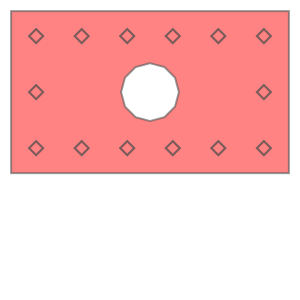

In [16]:
geom.create_mesh(mesh_sizes=[2000])

In [17]:
geom.mesh['vertices'].shape

(768, 2)

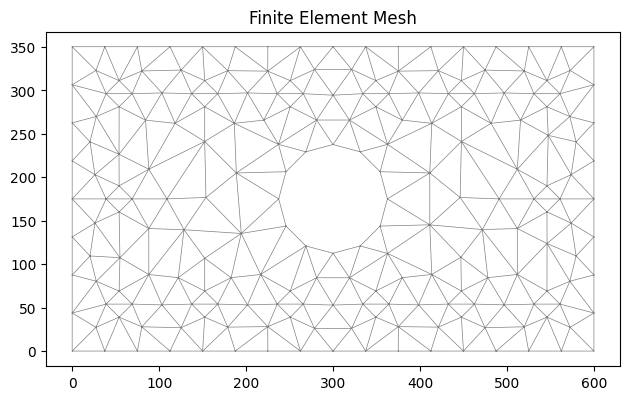

<Axes: title={'center': 'Finite Element Mesh'}>

In [18]:
Section(geometry=geom).plot_mesh(materials=False)

In [13]:
geom.mesh

{'vertices': array([[600.        ,   0.        ],
        [  0.        ,   0.        ],
        [  0.        , 350.        ],
        ...,
        [583.03351347, 336.6559465 ],
        [583.23654233, 336.86490531],
        [592.45065546, 167.77975727]]),
 'vertex_markers': array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]], dtype=int32),
 'triangles': array([[    646,     650,     656,  315258,  315259,  315257],
        [   2211,    1464,    2212,  315261,  315262,  315260],
        [    222,     125,     127,  315264,  315265,  315263],
        ...,
        [ 315256,  286481,  290952, 1179125, 1258712, 1197269],
        [ 290948,  315256,  290952, 1258712, 1197277, 1197278],
        [ 280134,  315255,  315256, 1197270, 1197275, 1179156]],
       dtype=int32),
 'triangle_attributes': array([[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]]),
 'segments': array([[     0, 298279],
        [     1,  31078],
   

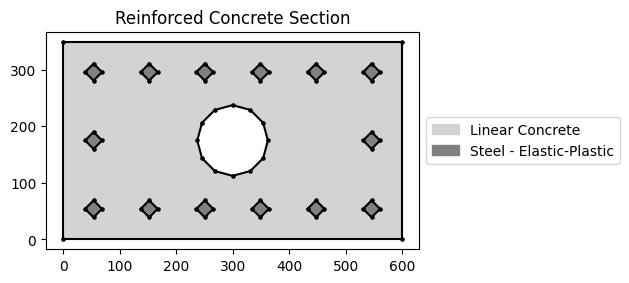

AttributeError: 'ConcreteSection' object has no attribute 'plot_mesh'

In [7]:
# initialise list to store results and list to store labels
moment_curvature_results = []
labels = []

# loop through each concrete material
for idx, conc in enumerate(conc_material_list):
    # assign concrete material to first geometry in CompoundGeometry object
    geom.geoms[0].material = conc

    # create ConcreteSection object
    conc_sec = ConcreteSection(geom)

    # plot section first time only
    if idx == 0:
        conc_sec.plot_section()
        conc_sec.plot_mesh()

    # perform moment curvature analysis and store results
    # bending about major axis so theta = pi/2
    res = conc_sec.moment_curvature_analysis(
        theta=np.pi / 2, kappa_inc=2.5e-7, progress_bar=False
    )
    moment_curvature_results.append(res)

    # create plot label
    labels.append(conc.name)

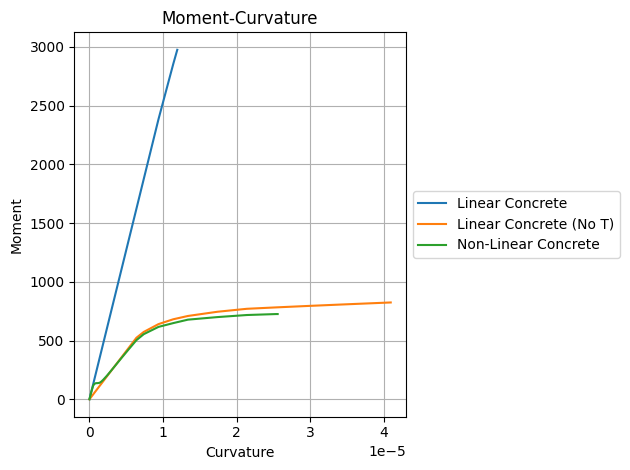

<Axes: title={'center': 'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [7]:
MomentCurvatureResults.plot_multiple_results(
    moment_curvature_results=moment_curvature_results, labels=labels, fmt="-"
)

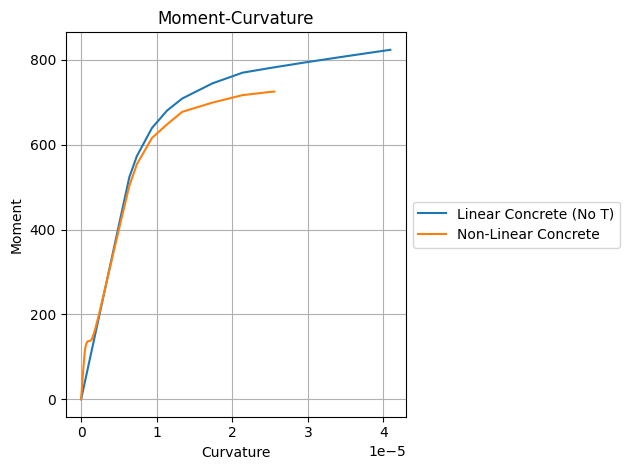

<Axes: title={'center': 'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [8]:
MomentCurvatureResults.plot_multiple_results(
    moment_curvature_results=moment_curvature_results[1:], labels=labels[1:], fmt="-"
)

In [9]:
geom.plot_mesh()

AttributeError: 'CompoundGeometry' object has no attribute 'plot_mesh'